# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Глоссарий**
- ОН — объект недвижимости

**Цель:** изучить данные и отыскать взаимосвязи для большинства объявлений, чтобы в будущем предсказывать цену ОН, а также подмечать аномалии в разных параметрах жилья. В дальнейшем это может помочь для обучения новых анти-фрод моделей или внедрения фич сервиса.

**Ход исследования:**
1. произвести предобработку данных (очистка и изменение данных, работа с аномалиями) 
2. дополнить данные новыми столбцами, необходимыми для исследования
3. проверить выбранные взаимосвязи

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

try:
    initial_data = pd.read_csv('real_estate_data.csv', sep='\t')
    initial_data.head()
except:
    print('Something is wrong. Check the file')

In [2]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

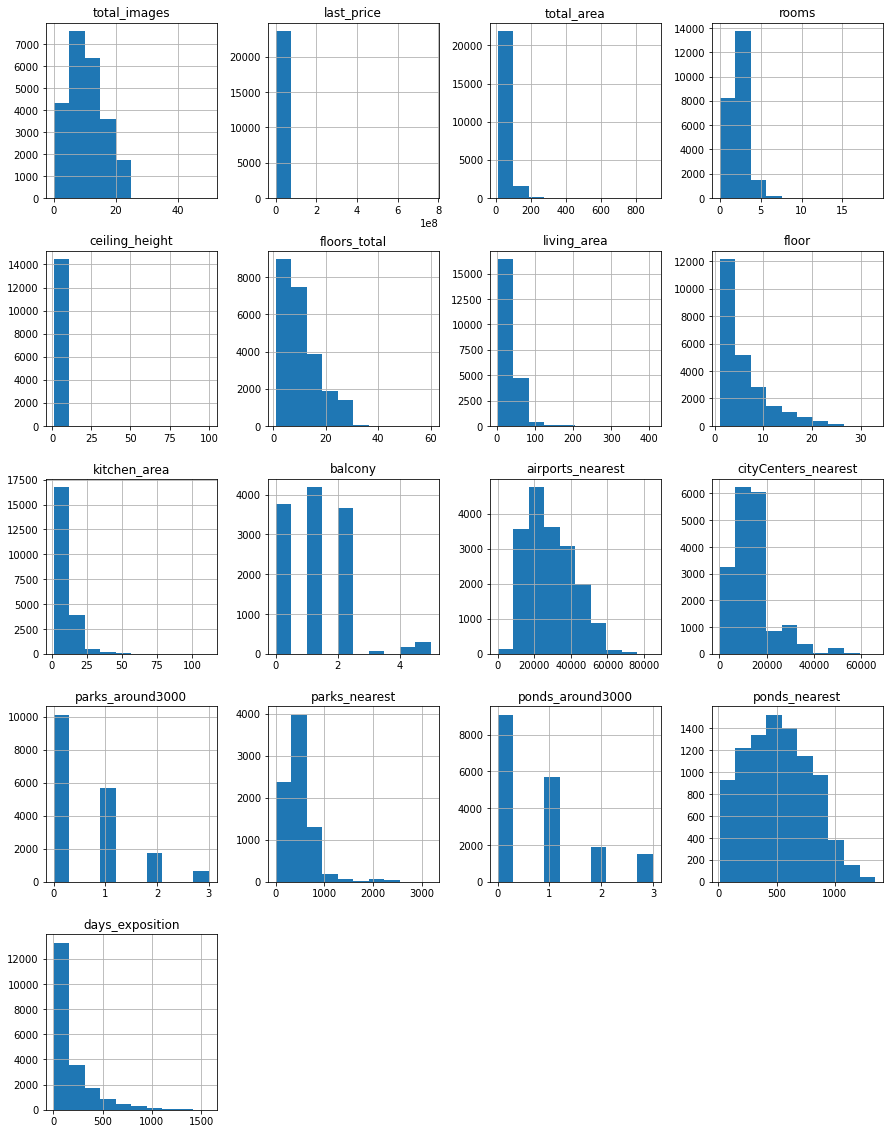

In [3]:
initial_data.hist(figsize=(15, 20));

### Предобработка данных

#### Работа с пропусками
В датасете видны пропущенные значения. Нужно понять, в каких столбцах они есть, сколько их и можно ли их заменить чем-либо или удалить.

In [4]:
#кол-во явных пропусков в данных
initial_data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [5]:
pd.DataFrame(round(initial_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Видим явные пропуски в данных:
- **is_apartment** (является ли апартаментами). Не указано для более 88% датафрейма. Пока трудно сказать, получится ли чем-нибудь заменить.
- **parks_nearest** (расстояние до ближ. парка, м). Не указано для более половины строк. Возможно, у большинства объявлений парков рядом просто нет, чтобы это отдельно выделять.
- **ponds_nearest** (расстояние до ближ. водоема, м). Думаю, пока стоит считать аналогичным пункту выше.
- **balcony** (кол-во балковов). Не указано почти для половины строк. Возможно, что эту характеристику не указывают, если балконов нет в принципе. Тогда можно будет заменить нулями.
- **ceiling_height** (высота потолков, м). Возможно заполнить медианными или средними значениями.
- **airports_nearest** (расстояние до ближ. аэропорта, м). Аналогично паркам и водоемам.
- **cityCenters_nearest** (расстояние до центра города, м). Есть гипотеза, что данных не будет, если объект недвижимости расположен не в городе.
- **ponds_around3000**, **parks_around3000** (число водоемов и парков в радиусе 3 км). Гипотеза: их может просто не быть, тогда пропуски можно заполнить нулями.
- **days_exposition** (сколько дней висело объявление). Не указано у чуть более 3000 строк. Может, это объявления, которые были удалены/скрыты в день публикации по каким-либо причинам. Если это так, что можно будет заполнить нулями.
- **kitchen_area** (площадь кухни в кв.м.). Нет у чуть более 2000 строк. Быть может, кухни у ОН нет. Пока трудно сказать.
- **living_area** (жилая площадь в кв.м.). Нет почти у 2000 строк. Возможно, ОН в объявлении не является жилым помещением (офис, гараж и пр.). Возможно, получится заменить медианными значениями.
- **floors_total** (кол-во этажей в доме). Не указано для менее 100 строк. Быть может, это немногоэтажные дома. Тогда можно будет заменить единицами.
- **locality_name** (название нас. пункта). Не указано почти для 50 строк. Пока трудно сказать, с чем это может быть связано.

Последовательно проверим все пропуски.

In [6]:
initial_data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Как мы видим, среди указанных данных неапартаментов гораздо больше. Вообще, апартаменты — это часто нежилые помещения (коммерческая недвижимость), в которых в приниципе можно жить, но в них не получится завести постоянную прописку. Есть и другие нюансы. Апартаменты часто бывают дешевле квартир, так как имеют меньше жилищных требований. Продавец или застройщик может привлечь внимание низкой ценой, но не указать, что ОН является апартаментами. Маловероятно, что без проверки каждого адреса получится точно понять, квартира это, апартаменты или гараж для хранения лодок. Следовательно, заполнить эти данные не получится корректно и можно заменить общей группой *«Тип не указан»* или оставить пропусками.

In [7]:
# датафрейм без пропусков будем собирать в data на тот случай, если нам в будущем потребуются исходные данные
data = initial_data.copy()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [8]:
# заполним общей группой
data['is_apartment'] = data['is_apartment'].fillna(False)
# проверяем, что пропусков больше нет
data['is_apartment'].isna().sum()

0

Переходим к **parks_nearest**, **ponds_nearest**, **airports_nearest**, **cityCenters_nearest**. Они все об одном и том же, но про разные картографические объекты. К сожалению, датафрейм не содержит информации о конкретных адресах, поэтому проверить возможные причины не удастся. Будем считать, что посчитать расстояние не удалось в виду отсутствия таких объектов. Придется оставить как есть.

Теперь **balcony**. Кол-во балконов может быть не указано, если балконов нет у ОН. В таком случае можно заполнить пропуски нулями.

In [9]:
# удостоверимся, какие есть значения
data['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Да, речь действительно о кол-ве балконов, но они записаны в типе *float*. Так как сейчас будем заполнять пропуски целочисленным значением (не может быть, например, полтора балкона), то заодно поменяем тип значений.

In [10]:
# заполним пропуски нулями
data['balcony'] = data['balcony'].fillna(0)
# меняем тип на int
data['balcony'] = data['balcony'].astype('int')

Разбираемся с кол-вом парков и водоемов в 3 километрах **ponds_around3000**, **parks_around3000**. Их может не быть, тогда пропуски имеет смысл заполнить нулями. 

In [11]:
# удостоверимся, что нули являются нормальным вариантом
display(data['ponds_around3000'].value_counts())
data['parks_around3000'].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

In [12]:
# заполним пропуски нулями
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
# и сразу поменяем тип данных для столбцов на int
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

Переходим к кол-ву дней «жизни» объявления **days_exposition**

In [13]:
# проверяем, какое минимальное кол-во дней держались объявления
data['days_exposition'].min()

1.0

В принципе можно счесть, что если кол-во дней не указано, то там не было даже одного дня, поэтому можно заменить нулем. При этом в дальнейшем анализе будем помнить, что эти нули могут смазать картину. Если это случится, на них просто закроем глаза. Сразу откорректируем типы.

In [14]:
data['days_exposition'] = data['days_exposition'].fillna(0)
data['days_exposition'] = data['days_exposition'].astype('int')

**floors_total** отвечает за количество этажей в доме. Если этажи не указали, то с большей долей вероятности в доме всего один этаж, поэтому можем заполнить единицами пропуски.

In [15]:
data['floors_total'] = data['floors_total'].fillna(1)
data['floors_total'] = data['floors_total'].astype('int')

**locality_name** обозначает название населенного пункта, и без адресов нельзя понять причину пропуска. Остается заполнить *«Город не указан»*.

In [16]:
data['locality_name'] = data['locality_name'].fillna('Город не указан')

Далее на очереди самое интересное: **kitchen_area** и **living_area**. Оба столбца показывают площадь, но обозначают разное. В жилых помещениях кухня обычно быть должна, как и санузел, а вот в коммерческой недвижимости её может не быть. Однако пропущено более 2000 значений, а точно известных апартаментов всего 50. Может ли быть так, что площадь кухни не указывают для квартир-студий?

In [17]:
# посмотрим, сколько студий и не студий
data['studio'].value_counts()

False    23550
True       149
Name: studio, dtype: int64

Нет, студий всего 149, поэтому пропуски скорее всего связаны с тем, что пользователь просто не стал указывать эту площадь отдельно. То же можно сказать о жилой площади, которая явно не может равна нулю для 1903 объявлений. Так как это количественные значения, то можно взять среднее или медианное значение в разбивке по кол-ву комнат в квартире. Сначала посмотрим, какие есть значения для стоблцов.

In [18]:
display(data['kitchen_area'].describe())
data['living_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Средние и медианные значения выглядят нормальными, но жилая площадь в 2 кв.м. или кухня в 1,3 кв.м. выглядят аномальными. Нам стоит избавиться от аномальных значений перед вычислением медианных значений. Построим гистограммы.

<AxesSubplot:>

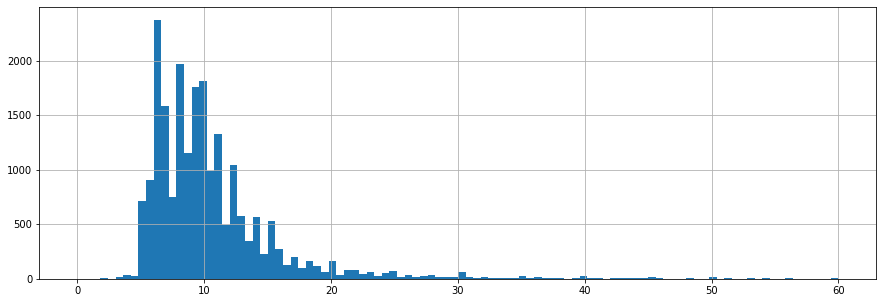

In [19]:
data['kitchen_area'].hist(bins=100, grid=True, figsize=(15,5), range=(0,60))

<AxesSubplot:>

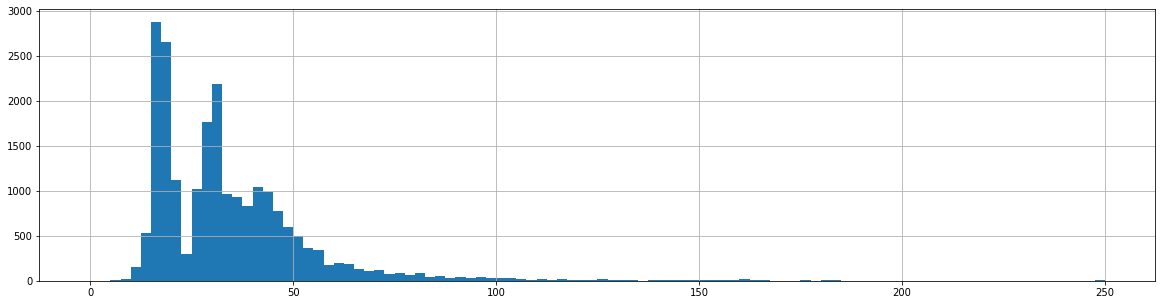

In [20]:
data['living_area'].hist(bins=100, grid=True, figsize=(20,5), range=(0,250))

Как видим, и кухни, и общая жилплощадь имеют аномальные выбросы:
- кухни имеет смысл рассматривать от 6 до 30 кв.м.
- жил площадь: от 12,5 до 75 кв.м. 
Жилая площадь не равна общей, так как сюда принято не относить кухню, санузел, балконы и пр. При этом жилая площадь распределена неравномерно. Есть большой провал в районе перед 25 кв.м. и два пика. Возможно, таких объявлений просто мало. Для однокомнатной квартиры площадь жилой комнаты в 12 кв.м. не вызывает удивления, как и большая площадь при увеличении числа комнат, поэтому отбросить левый пик нельзя.

In [21]:
# уберем аномальные значения
kitchen_area_good = data.query('kitchen_area >= 6 and kitchen_area <= 30')
display(kitchen_area_good['kitchen_area'].describe())
# сколькикомнатные квартиры есть
display(kitchen_area_good['rooms'].value_counts())
# посмотрим сводную таблицу соотношения комнат на медиану
kitchen_area_good.pivot_table(index='rooms', values='kitchen_area', aggfunc='median')

count    19395.000000
mean        10.509380
std          4.114964
min          6.000000
25%          7.900000
50%          9.650000
75%         12.000000
max         30.000000
Name: kitchen_area, dtype: float64

1     6613
2     6533
3     4911
4      933
5      257
6       83
7       46
8        6
9        4
10       3
11       2
14       2
16       1
19       1
Name: rooms, dtype: int64

,kitchen_area
rooms,
1,9.50
2,9.00
3,9.90
4,11.30
5,15.00
6,18.00
7,19.20
8,24.30
9,12.80


На квартиры более 8 комнат ориентироваться нельзя, так как их мало. Их мы оставим пустыми и уберем.

In [22]:
# сделаем словарь из медианных значений по разнокомнатным квартирам
median_kitchen_area_by_rooms = {
    1: 9.5,
    2: 9.0,
    3: 9.5,
    4: 10.8,
    5: 13.8,
    6: 15.2,
    7: 16.0
}
# итерационно заполним пропуски для квартир с разным кол-вом комнат
for i in median_kitchen_area_by_rooms:
    data.loc[(data['rooms'] == i) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data['kitchen_area'].fillna(median_kitchen_area_by_rooms[i])

# оставим в датасете квартиры, где кол-во комнат меньше 8, а также кухни нужного размера
data = data.query('rooms < 8')
data = data.query('kitchen_area >= 6 and kitchen_area <= 30')

In [23]:
# уберем аномальные значения
living_area_good = data.query('living_area >= 12 and living_area <= 75')
display(living_area_good['living_area'].describe())
# сколькикомнатные квартиры есть
display(living_area_good['rooms'].value_counts())
# посмотрим сводную таблицу соотношения комнат на медиану
living_area_good.pivot_table(index='rooms', values='living_area', aggfunc='median')

count    18759.000000
mean        31.874597
std         13.848252
min         12.000000
25%         18.600000
50%         30.000000
75%         41.800000
max         75.000000
Name: living_area, dtype: float64

1    6680
2    6540
3    4778
4     688
5      66
6       5
7       2
Name: rooms, dtype: int64

,living_area
rooms,
1,17.7
2,30.9
3,45.0
4,58.8
5,66.3
6,73.6
7,65.8


In [24]:
# сделаем словарь из медианных значений по разнокомнатным квартирам
median_living_area_by_rooms = {
    0: 18.0,
    1: 17.7,
    2: 30.5,
    3: 44.5,
    4: 57.1,
    5: 66.1,
    6: 71.8,
    7: 65.8
}
# итерационно заполним пропуски для квартир с разным кол-вом комнат
for i in median_living_area_by_rooms:
    data.loc[(data['rooms'] == i) & (data['living_area'].isna()), 'living_area'] = \
    data['living_area'].fillna(median_living_area_by_rooms[i])
data = data.query('living_area >= 12 and living_area <= 75')

Осталась высота потолков **ceiling_height**. Взглянем на значения.

In [25]:
data.groupby('ceiling_height', as_index=False).count().sort_values('ceiling_height', ascending=False)

,ceiling_height,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
159,100.00,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
158,32.00,2,2,2,2,2,2,2,2,2,...,2,2,2,1,1,2,0,2,1,2
157,27.50,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,1
156,27.00,7,7,7,7,7,7,7,7,7,...,7,7,7,3,3,7,0,7,2,7
155,26.00,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2.34,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,0,1,0,1
3,2.30,2,2,2,2,2,2,2,2,2,...,2,2,2,1,1,2,1,2,1,2
2,2.00,11,11,11,11,11,11,11,11,11,...,11,11,11,3,3,11,2,11,2,11
1,1.75,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1


<AxesSubplot:>

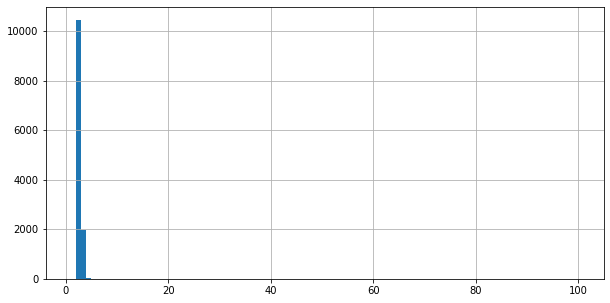

In [26]:
data['ceiling_height'].hist(bins=100, figsize=(10,5))

Есть аномальные значения. Вероятно, в части двухзначных данных может быть не там стоять запятая, но высоту потолков меньше 2 метров и больше 3,2 стоит считать аномальной.

<AxesSubplot:>

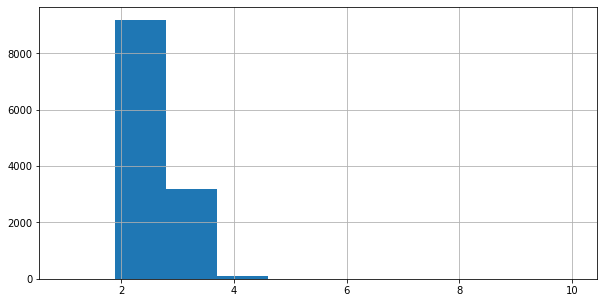

In [27]:
# избавляемся от двухзначных чисел высоты потолков
data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] / 10
# построим гистограмму, чтобы убедиться
data['ceiling_height'].hist(bins=10, figsize=(10,5))

In [28]:
# убираем из датасета объявления с аномальными высотами потолков
data = data.query('ceiling_height >= 2 and ceiling_height <= 3.2')
# заполняем пропуски медианами
data['ceiling_height'] = data['ceiling_height'].fillna(data.loc[~(data['ceiling_height'].isna()), 'ceiling_height'].median())

In [29]:
data.isna().sum().sort_values(ascending=False)

parks_nearest           7959
ponds_nearest           7539
airports_nearest        2546
cityCenters_nearest     2531
total_images               0
last_price                 0
ponds_around3000           0
parks_around3000           0
locality_name              0
balcony                    0
kitchen_area               0
open_plan                  0
studio                     0
is_apartment               0
floor                      0
living_area                0
floors_total               0
ceiling_height             0
rooms                      0
first_day_exposition       0
total_area                 0
days_exposition            0
dtype: int64

Мы избавились от всех пропусков, насколько это было возможно. Дополнительно убрали из датасета часть аномальных данных. Переходим к дальнейшей предобработке.

#### Поиск дубликатов
Теперь нужно проверить полные дубликаты и неполные, например, в названии населенных пунктов могут быть неявные дубликаты.

In [30]:
# проверяем наличие явных дубликатов
data.duplicated().sum()

0

In [31]:
# для вывода всех строк можно раскомментировать строку ниже
#pd.set_option('display.max_rows', None)
# проверяем неявные дубликаты в названии нас. пунктов
data['locality_name'].value_counts()

Санкт-Петербург            8326
Всеволожск                  250
посёлок Шушары              194
посёлок Мурино              190
Колпино                     188
                           ... 
Высоцк                        1
деревня Кисельня              1
посёлок станции Громово       1
деревня Ваганово              1
деревня Разметелево           1
Name: locality_name, Length: 265, dtype: int64

Обнаружены следующие неявные дубликаты:
- посёлок Мурино, Мурино, поселок Мурино
- посёлок Бугры, поселок Бугры 
- посёлок городского типа Кузьмоловский, поселок городского типа Кузьмоловский 
- поселок городского типа Рощино, посёлок городского типа Рощино 
- деревня Кудрово, Кудрово
- городской посёлок Янино-1, городской поселок Янино-1 
- посёлок Тельмана, поселок Тельмана 
- городской посёлок Мга, посёлок городского типа Мга
- посёлок Новый Свет, поселок Новый Свет
- поселок городского типа имени Свердлова, посёлок городского типа имени Свердлова
- поселок городского типа Рощино, посёлок городского типа Рощино, городской посёлок Рощино  
- деревня Гарболово, поселок Гарболово
- посёлок городского типа Лебяжье, поселок городского типа Лебяжье 
- посёлок городского типа Павлово, городской посёлок Павлово
- деревня Фёдоровское, городской посёлок Фёдоровское
- поселок городского типа Советский , городской посёлок Советский
- посёлок Аннино, поселок Аннино
- посёлок Кобралово, поселок Кобралово 
- посёлок Ильичёво, поселок Ильичёво
- поселок городского типа Вырица, посёлок городского типа Вырица
- посёлок Мичуринское, поселок Мичуринское
- поселок городского типа Красный Бор, посёлок городского типа Красный Бор
- поселок Стеклянный,посёлок Стеклянный
- поселок станции Вещево, посёлок при железнодорожной станции Вещево 
- поселок Победа, посёлок Победа
- посёлок Поляны , поселок Поляны  
- посёлок Петровское, поселок Петровское
- посёлок Терволово, поселок Терволово
- посёлок городского типа Рябово, поселок Рябово
- посёлок Мельниково, поселок Мельниково
- поселок Возрождение, посёлок Возрождение
- поселок Лисий Нос, посёлок Лисий Нос
- посёлок Коробицыно, поселок Коробицыно
- поселок станции Приветнинское, посёлок при железнодорожной станции Приветнинское 
- поселок Сумино, посёлок Сумино

In [32]:
# исправим дубликаты
data['locality_name'] = data['locality_name'].replace('посёлок Мурино', 'поселок Мурино')
data['locality_name'] = data['locality_name'].replace('посёлок Бугры', 'поселок Бугры')
data['locality_name'] = data['locality_name'].replace('Мурино', 'поселок Мурино')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Кузьмоловский', 'поселок городского типа Кузьмоловский')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Рощино', 'поселок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace('Кудрово', 'деревня Кудрово')
data['locality_name'] = data['locality_name'].replace('городской посёлок Янино-1', 'городской поселок Янино-1')
data['locality_name'] = data['locality_name'].replace('посёлок Тельмана', 'поселок Тельмана')
data['locality_name'] = data['locality_name'].replace('городской посёлок Мга', 'посёлок городского типа Мга')
data['locality_name'] = data['locality_name'].replace('посёлок Новый Свет', 'поселок Новый Свет')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа имени Свердлова', 'поселок городского типа имени Свердлова')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Рощино', 'поселок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace(' городской посёлок Рощино', 'поселок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace('деревня Гарболово', 'поселок Гарболово')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Лебяжье', 'поселок городского типа Лебяжье')
data['locality_name'] = data['locality_name'].replace('городской посёлок Павлово', 'посёлок городского типа Павлово')
data['locality_name'] = data['locality_name'].replace('деревня Фёдоровское', 'городской посёлок Фёдоровское')
data['locality_name'] = data['locality_name'].replace('городской посёлок Советский', 'поселок городского типа Советский')
data['locality_name'] = data['locality_name'].replace('посёлок Аннино', 'поселок Аннино')
data['locality_name'] = data['locality_name'].replace('посёлок Кобралово', 'поселок Кобралово')
data['locality_name'] = data['locality_name'].replace('посёлок Ильичёво', 'поселок Ильичёво')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Вырица', 'поселок городского типа Вырица')
data['locality_name'] = data['locality_name'].replace('посёлок Мичуринское', 'поселок Мичуринское')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Красный Бор', 'поселок городского типа Красный Бор')
data['locality_name'] = data['locality_name'].replace('посёлок Стеклянный', 'посёлок Стеклянный')
data['locality_name'] = data['locality_name'].replace('посёлок при железнодорожной станции Вещево', 'поселок станции Вещево')
data['locality_name'] = data['locality_name'].replace('посёлок Победа', 'поселок Победа')
data['locality_name'] = data['locality_name'].replace('посёлок Поляны', 'поселок Поляны')
data['locality_name'] = data['locality_name'].replace('посёлок Петровское', 'поселок Петровское')
data['locality_name'] = data['locality_name'].replace('посёлок Терволово', 'поселок Терволово')
data['locality_name'] = data['locality_name'].replace('посёлок городского типа Рябово', 'поселок Рябово')
data['locality_name'] = data['locality_name'].replace('посёлок Мельниково', 'поселок Мельниково')
data['locality_name'] = data['locality_name'].replace('посёлок Возрождение', 'поселок Возрождение')
data['locality_name'] = data['locality_name'].replace('посёлок Лисий Нос', 'поселок Лисий Нос')
data['locality_name'] = data['locality_name'].replace('посёлок Коробицыно', 'поселок Коробицыно')
data['locality_name'] = data['locality_name'].replace('посёлок при железнодорожной станции Приветнинское', 'поселок станции Приветнинское')
data['locality_name'] = data['locality_name'].replace('посёлок Сумино', 'поселок Сумино')

#### Типы данных в столбцах
Проверим, остались ли столбцы, в которых имеет смысл изменить тип данных.

In [33]:
# посмотрим на текущий датафрейм
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11994 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          11994 non-null  int64  
 1   last_price            11994 non-null  float64
 2   total_area            11994 non-null  float64
 3   first_day_exposition  11994 non-null  object 
 4   rooms                 11994 non-null  int64  
 5   ceiling_height        11994 non-null  float64
 6   floors_total          11994 non-null  int64  
 7   living_area           11994 non-null  float64
 8   floor                 11994 non-null  int64  
 9   is_apartment          11994 non-null  bool   
 10  studio                11994 non-null  bool   
 11  open_plan             11994 non-null  bool   
 12  kitchen_area          11994 non-null  float64
 13  balcony               11994 non-null  int64  
 14  locality_name         11994 non-null  object 
 15  airports_nearest   

In [34]:
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289
10,5,5050000.0,39.6,2017-11-16T00:00:00,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137
16,11,6700000.0,82.0,2017-11-23T00:00:00,3,3.05,5,55.6,1,False,False,False,9.0,0,Санкт-Петербург,22108.0,10698.0,3,420.0,0,NaN,397
20,12,6120000.0,80.0,2017-09-28T00:00:00,3,2.70,27,48.0,11,False,False,False,12.0,2,посёлок Парголово,53134.0,19311.0,0,NaN,0,NaN,74


Видим, что **first_day_exposition** записано не как дата. Это стоит исправить. 
Также для цены теоретически могут быть указаны копейки, но в рамках текущего исследования они ни на что не повлияют, поэтому можно представить целочисленными значениями. Значения расстояния оставим как есть, так как без доп. манипуляций не получится привести весь столбец к целочисленным значениям из-за пропусков.

In [35]:
# изменим даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,False,False,9.0,0,Санкт-Петербург,22108.0,10698.0,3,420.0,0,NaN,397
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,False,False,12.0,2,посёлок Парголово,53134.0,19311.0,0,NaN,0,NaN,74


Видим, что часы и минуты отбросились, значит, везде была указана полночь. Нам этого хватит. Теперь остальные столбцы.

In [36]:
data['last_price'] = data['last_price'].astype('int')

#### Работа с аномальными данными
Стоит проверить, не осталось ли в датафрейме каких-либо еще однозначно аномальных данных, которые стоит убрать. Стоит проверить:
- last_price
- total_area
- floors_total
- days_exposition
- total_area
- living_area
- kitchen_area

In [37]:
display(data['last_price'].describe().apply(lambda x: format(x, 'f')))
display(data['total_area'].describe())
display(data['floors_total'].describe())
display(data['days_exposition'].describe())

count        11994.000000
mean       5745727.327080
std        4506244.617882
min         450000.000000
25%        3600000.000000
50%        4800000.000000
75%        6599750.000000
max      150000000.000000
Name: last_price, dtype: object

count    11994.000000
mean        56.943578
std         22.601021
min         13.000000
25%         41.000000
50%         52.700000
75%         68.000000
max        500.000000
Name: total_area, dtype: float64

count    11994.000000
mean        10.899366
std          6.242584
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

count    11994.000000
mean       153.528348
std        213.046666
min          0.000000
25%         18.000000
50%         71.000000
75%        196.000000
max       1580.000000
Name: days_exposition, dtype: float64

Вопрос вызывает цена. Если 150 млн. в Питере для элитного жилья не будет вызывать вопросы, то 12190 рублей — слишком низкая цена для недвижимости. При этом верхние значения тоже лучше отбросить до 40 млн. рублей. Посмотрим диаграмму.

<AxesSubplot:>

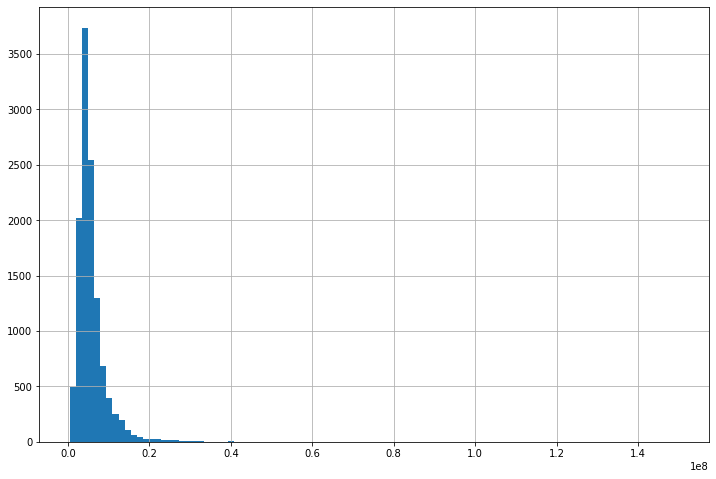

In [38]:
data['last_price'].hist(bins=100, figsize=(12,8))

<AxesSubplot:>

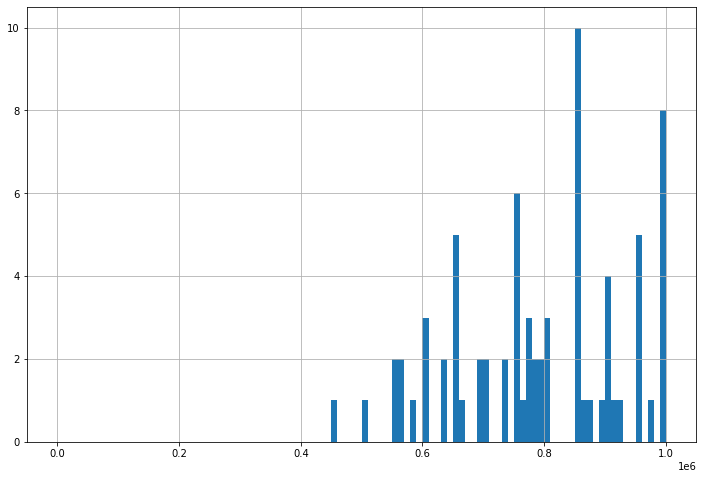

In [39]:
# приблизим левую границу
data['last_price'].hist(bins=100, figsize=(12,8), range=(0, 1000000))

Аномально низкое значение хорошо выделяется. Можно считать, что суммы от 500 000 рублей можно брать для анализа. 

In [40]:
data = data.query('last_price > 500000 and last_price < 40000000')
data['last_price'].describe().apply(lambda x: format(x, 'f'))

count       11976.000000
mean      5656649.962675
std       3516586.840846
min        550000.000000
25%       3600000.000000
50%       4800000.000000
75%       6580000.000000
max      39990000.000000
Name: last_price, dtype: object

На всякий случай проверим картографические данные, на тот случай, если там присутствуют ненормально большие значения, например, превышающие размеры Ленинградской области.

In [41]:
display(data['cityCenters_nearest'].describe())
display(data['ponds_nearest'].describe())
display(data['parks_nearest'].describe())

count     9447.000000
mean     14541.543135
std       8022.030546
min        329.000000
25%      10574.000000
50%      13377.000000
75%      16140.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

count    4444.000000
mean      532.972997
std       278.627790
min        16.000000
25%       312.000000
50%       521.000000
75%       746.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

count    4021.000000
mean      485.902761
std       323.016040
min         3.000000
25%       288.000000
50%       459.000000
75%       610.000000
max      2905.000000
Name: parks_nearest, dtype: float64

В целом нет ничего выбивающегося. Дом может быть впритык к парку, как и рядом с водоемом.

count    11976.000000
mean        56.717783
std         21.243196
min         13.000000
25%         41.000000
50%         52.600000
75%         68.000000
max        422.200000
Name: total_area, dtype: float64

<AxesSubplot:>

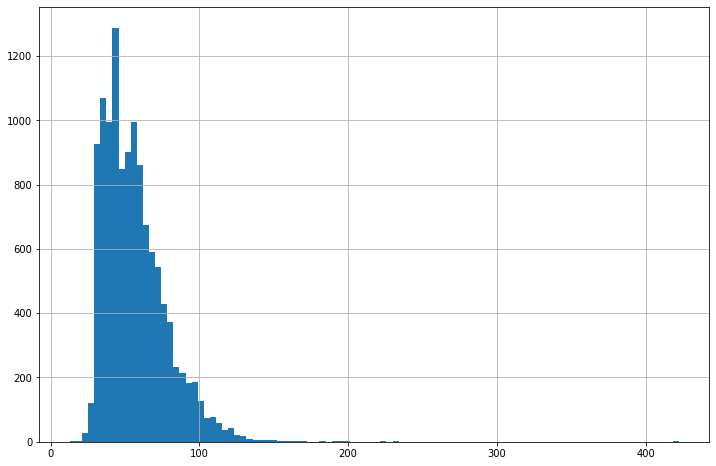

In [42]:
# проверим также общую площадь
display(data['total_area'].describe())
data['total_area'].hist(bins=100, figsize=(12,8))

ОН с 500 кв.м., конечно, может существовать, но для статистики такие значения не будут сейчас играть важной роли, поэтому можно избавиться от всего больше 200 кв.м.

In [43]:
data = data.query('total_area <= 200')

Напоследок пересчитаем все индексы.

In [44]:
data = data.reset_index(drop=True)

### Посчитайте и добавьте в таблицу новые столбцы

In [45]:
# добавим столбец с ценой за кв. метр
data['price_per_square_meter'] = data['last_price'] / data['total_area']

In [46]:
# укажем в новом столбце день недели публикации (0 — понедельник, ..., 6 — воскресение)
data['publication_day'] = data['first_day_exposition'].dt.weekday

In [47]:
# то же сделаем для месяца и года
data['publication_month'] = data['first_day_exposition'].dt.month
data['publication_year'] = data['first_day_exposition'].dt.year

In [48]:
# укажем тип этажа (первый, последний, другой)
data['floor_type'] = 'Другой'
data['floor_type'] = data['floor_type'].where(~(data['floor'] == 1), other='Первый')
data['floor_type'] = data['floor_type'].where(~((data['floor'] == data['floors_total']) & ~(data['floor'] == 1)), other='Последний')

In [49]:
# укажем расстояние до центра города в километрах
data['distance_to_center'] = round(data['cityCenters_nearest'] / 1000)

In [50]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,publication_day,publication_month,publication_year,floor_type,distance_to_center
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.370370,3,3,2019,Другой,16.0
1,18,5400000,61.00,2017-02-26,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289,88524.590164,6,2,2017,Другой,15.0
2,5,5050000,39.60,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137,127525.252525,3,11,2017,Другой,14.0
3,11,6700000,82.00,2017-11-23,3,3.05,5,55.6,1,False,False,False,9.0,0,Санкт-Петербург,22108.0,10698.0,3,420.0,0,NaN,397,81707.317073,3,11,2017,Первый,11.0
4,12,6120000,80.00,2017-09-28,3,2.70,27,48.0,11,False,False,False,12.0,2,посёлок Парголово,53134.0,19311.0,0,NaN,0,NaN,74,76500.000000,3,9,2017,Другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11968,13,3550000,35.30,2018-02-28,1,2.86,15,16.3,4,False,False,False,9.1,2,Санкт-Петербург,17284.0,16081.0,1,353.0,2,652.0,29,100566.572238,2,2,2018,Другой,16.0
11969,11,9470000,72.90,2016-10-13,2,2.75,25,40.3,7,False,False,False,10.6,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519,129903.978052,3,10,2016,Другой,4.0
11970,9,4600000,62.40,2016-08-05,3,2.60,9,40.0,8,False,False,False,8.0,0,Петергоф,45602.0,34104.0,1,352.0,1,675.0,239,73717.948718,4,8,2016,Другой,34.0
11971,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False,False,False,23.3,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602,149511.400651,1,3,2017,Другой,10.0


### Проведите исследовательский анализ данных

#### Изучение параметров
Изучим различные параметры датафрейма, а именно:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

<AxesSubplot:>

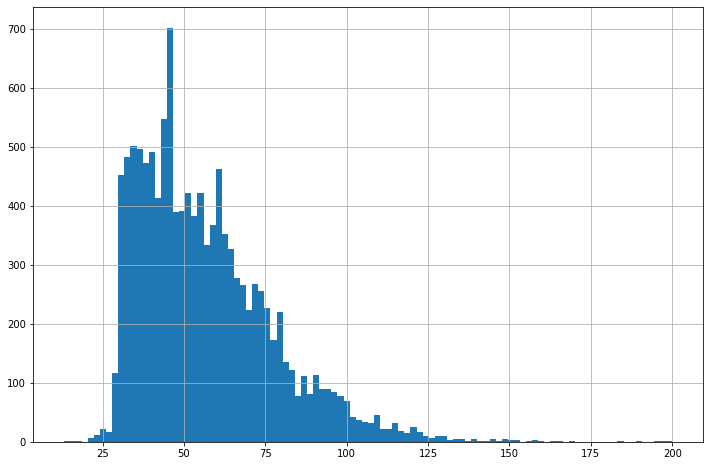

In [51]:
data['total_area'].hist(bins=100, figsize=(12,8))

По общей площади можно диаграмма стремится к нормальному состоянию: кол-во предложений начинает возрастать после 25 кв.м., достигает пика после 50 кв.м., а потом идет на убыль. С точки зрения логики выглядит правильно: маленьких квартир и дворцов явно будет продаваться меньше всего, так как такого жилья меньше всего.

<AxesSubplot:>

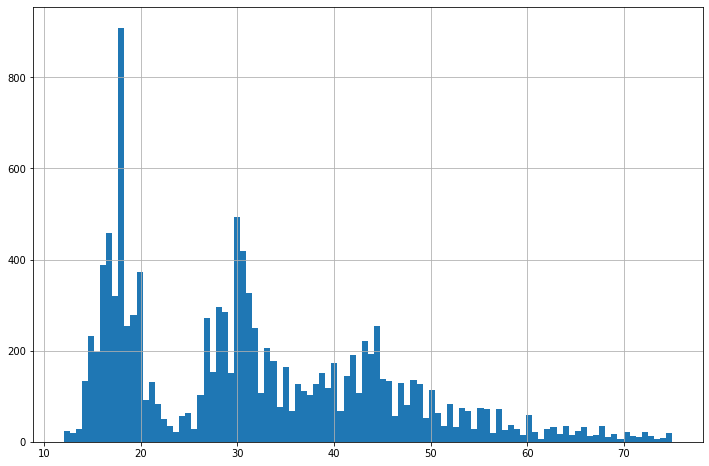

In [52]:
data['living_area'].hist(bins=100, figsize=(12,8))

Жилая площадь тоже походит на нормально распределение, но имеет провал, который ранее уже видели. Видим, что очень мало предложений с жилой площадью от 20 до 28 кв.м. 

<AxesSubplot:>

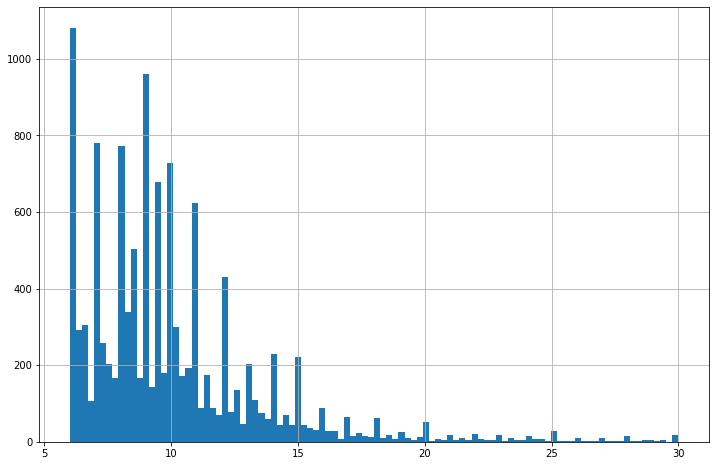

In [53]:
data['kitchen_area'].hist(bins=100, figsize=(12,8))

Площадь кухонь имеет много пиков, но сами значения правдоподобны. Больше всего предложений с 6 кв.м., потом колеблется с целочисленными шагами, пока постепенно не снижается до очень редких предложений. 

<AxesSubplot:>

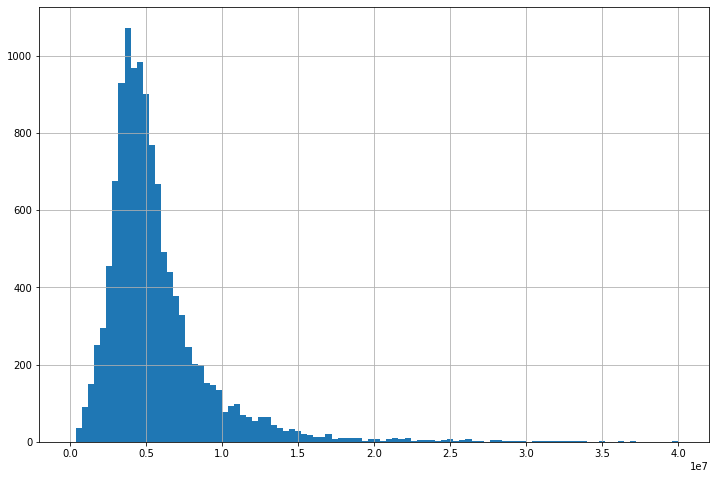

In [54]:
data['last_price'].hist(bins=100, figsize=(12,8), range=(0, 40000000))

Цена распределяется нормально. Достигает пика в районе 4 млн., потом постепенно идет на убыль до 40 млн. Очень дорогого жилья ожидаемо меньше.

<AxesSubplot:>

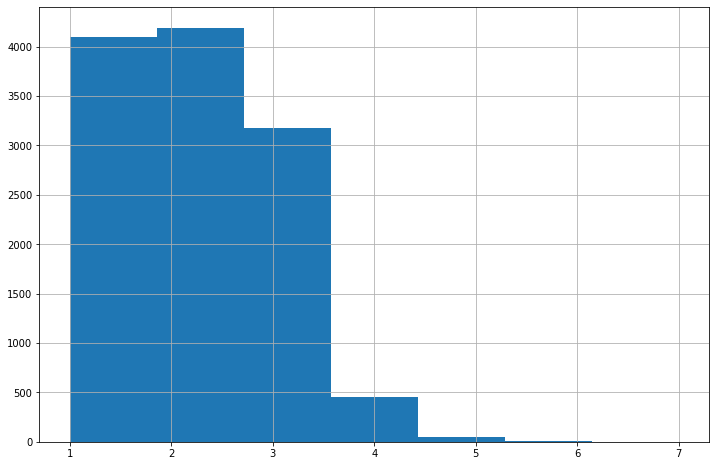

In [55]:
data['rooms'].hist(bins=7, figsize=(12,8))

Можно сделать вывод, что самые распространенные предложения для 1, 2 и 3-комнатных квартир, причем двухкомантых больше всего.

<AxesSubplot:>

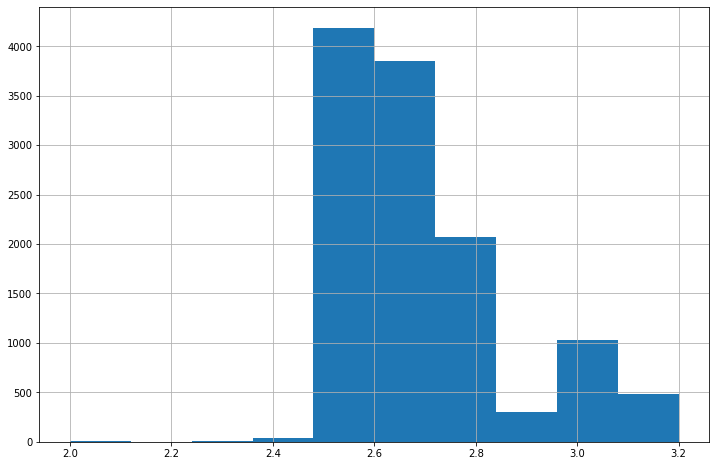

In [56]:
data['ceiling_height'].hist(bins=10, figsize=(12,8))

Самая распространенная высота потолков: 2,5-2,6 метра. Выглядит логично, так как это нижняя допустимая граница для жилого жилья.

<AxesSubplot:>

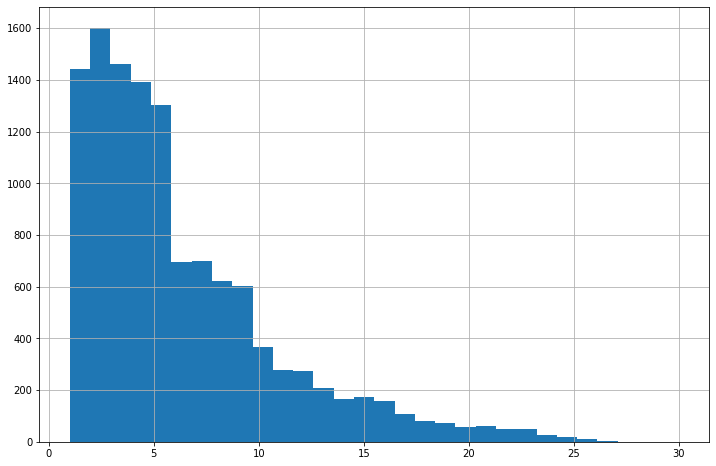

In [57]:
data['floor'].hist(bins=30, figsize=(12,8))

Чаще продают ОН на 2-6 этажах. Домов выше 10-12 этажей в целом просто меньше, что можно увидеть на следующем графике. 

<AxesSubplot:>

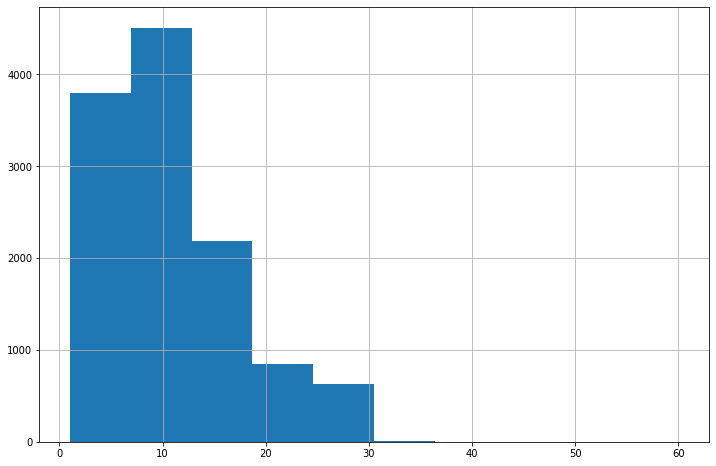

In [58]:
data['floors_total'].hist(bins=10, figsize=(12,8))

<AxesSubplot:>

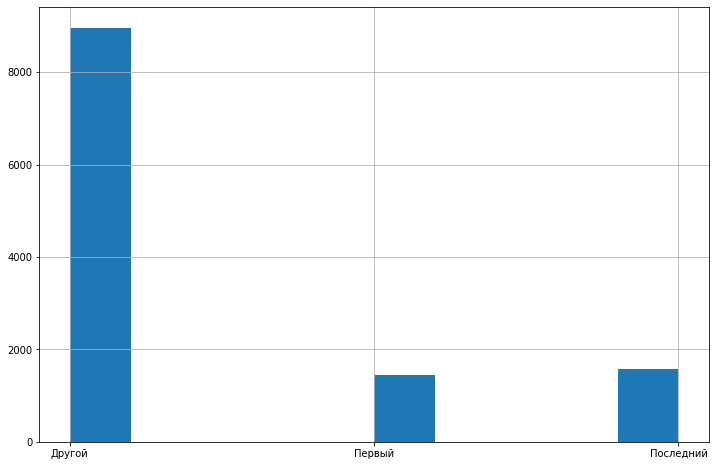

In [59]:
data['floor_type'].hist(figsize=(12,8))

Подавляющее кол-во предложений о продаже ОН между первым и последним этажом. 

<AxesSubplot:>

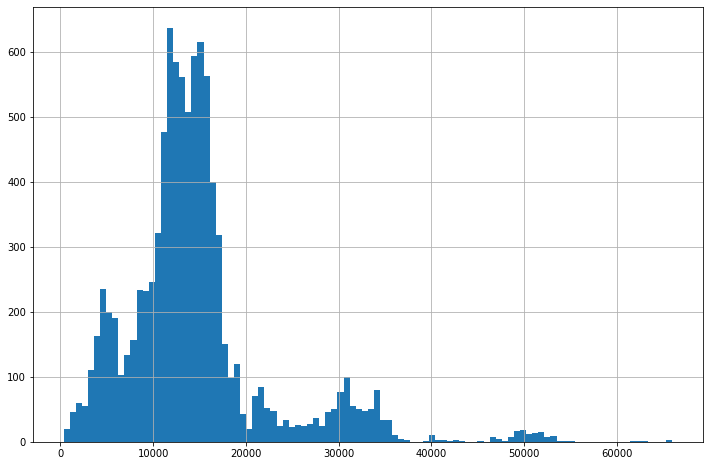

In [60]:
data['cityCenters_nearest'].hist(bins=100, figsize=(12,8))

Расстояние до центра города для большинства ОН колеблется от 10 до 20 км. Распределение выглядит нормальным. Для Санкт-Петербурга такие расстояния до центра выглядят нормальными, а в случае деревень и поселков тем более.

<AxesSubplot:>

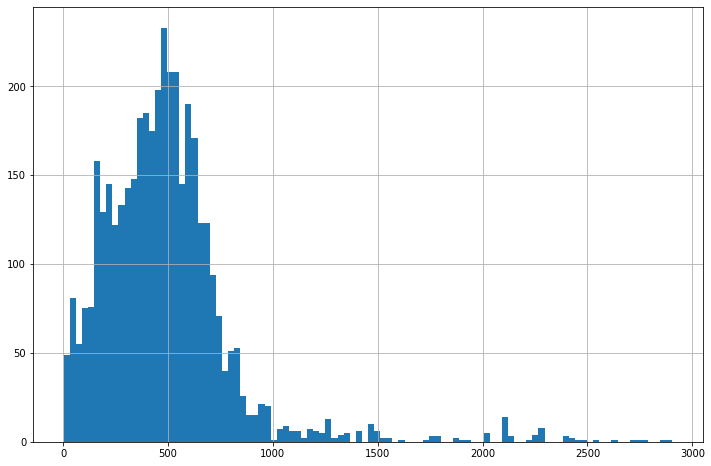

In [61]:
data['parks_nearest'].hist(bins=100, figsize=(12,8))

Как мы видим, для большинства ОН парк есть в районе 1 км. 

<AxesSubplot:>

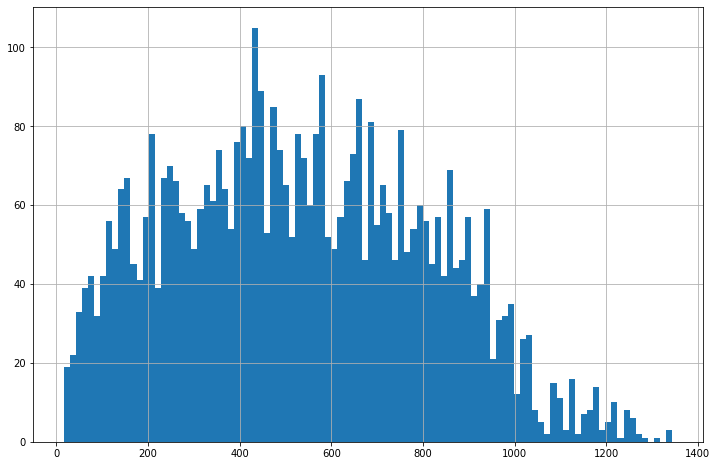

In [62]:
data['ponds_nearest'].hist(bins=100, figsize=(12,8))

То же справедливо для водоемов. Больше всего предложений в районе 400-600 метров от дома.

<AxesSubplot:>

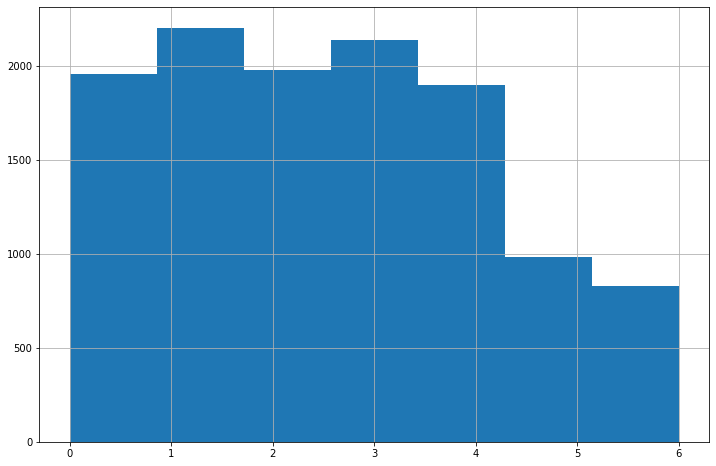

In [63]:
data['publication_day'].hist(bins=7, figsize=(12,8))

Чаще всего публикуют по будням, и почти в два раза реже в выходные дни.

<AxesSubplot:>

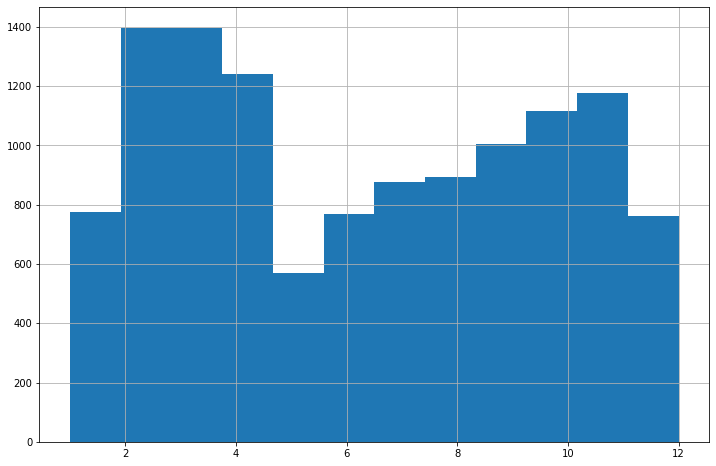

In [64]:
data['publication_month'].hist(bins=12, figsize=(12,8))

Чаще всего продают в феврале-марте, а также в ноябре, а больший провал приходится на май.

#### Как быстро продавались квартиры?

<AxesSubplot:>

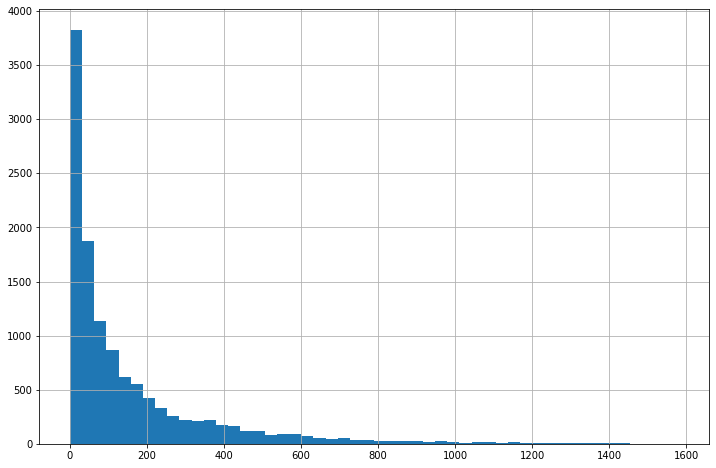

In [65]:
# посмотрим на гистограмму
data['days_exposition'].hist(bins=50, figsize=(12,8))

<AxesSubplot:>

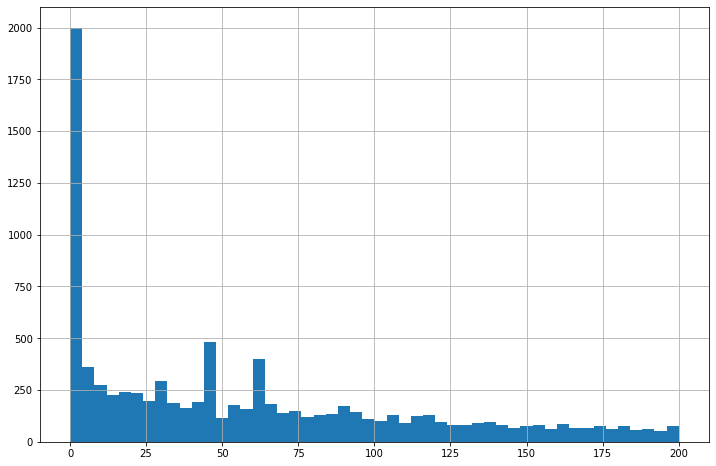

In [66]:
data['days_exposition'].hist(bins=50, figsize=(12,8), range=(0, 200))

Как мы видим, большинство занимает 0 дней, что может говорить о том, что такие объявления снимались в тот же день, однако, вряд ли это можно считать покупкой квартиры, так как это были пропуски ранее. На такие объявления стоит в дальнейшем смотреть внимательно, так как это могут быть фейковые предложения ОН, нарушения правил. Или риэлторы мониторят новые предложения собственников и сразу бросаются договариваться с ними, чтобы предложить услуги и потом действовать от лица своего аккаунта. 

Стоит рассмотреть те случаи, когда объявление продержалось хотя бы 1 день.

<AxesSubplot:>

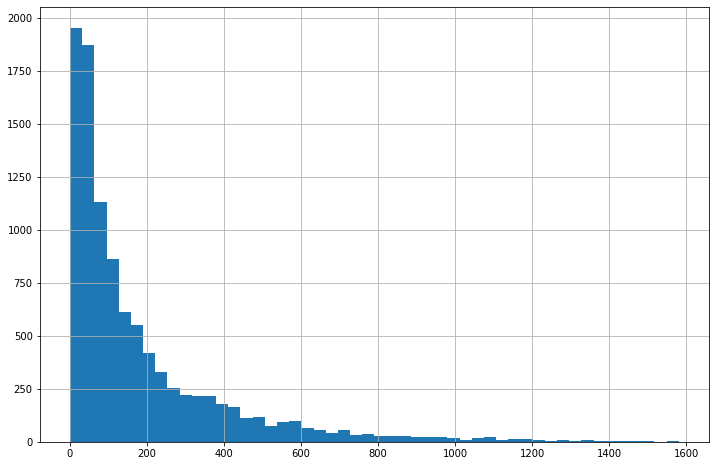

In [67]:
good_days = data.query('days_exposition >= 1')
good_days['days_exposition'].hist(bins=50, figsize=(12,8))

<AxesSubplot:>

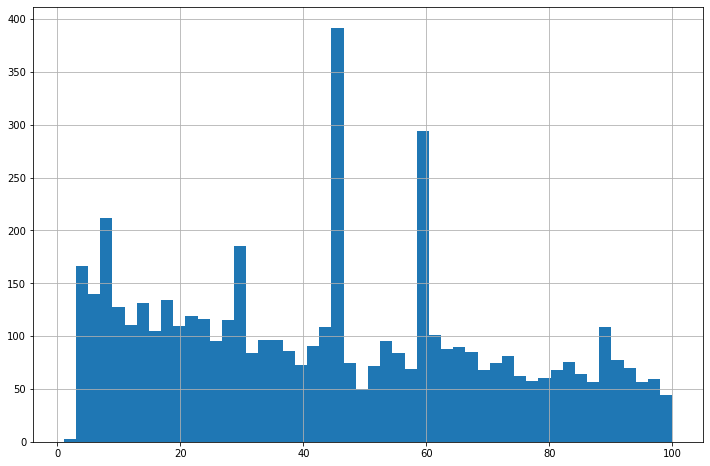

In [68]:
good_days['days_exposition'].hist(bins=50, figsize=(12,8), range=(1, 100))

Поведение графика не сильно изменилось, мы видим постоянно понижение, что логично, ведь шанс продажи ОН повышается вместе с увеличением срока продажи. До разумного предела, разумеется, ведь если требования слишком высоки или ОН в слишком плохом состоянии, то есть риск вообще не продать такой ОН. Чаще всего требуется от 1-2 месяца для большинства объявления для закрытия. При этом есть предложения, которые висят годами. Для расчета среднего и медианы предлагаю ограничить верхний предел 800 днями.

In [69]:
good_days = good_days.query('days_exposition <= 800')
good_days['days_exposition'].describe()

count    9772.000000
mean      158.086472
std       166.209567
min         1.000000
25%        43.000000
50%        93.000000
75%       216.000000
max       800.000000
Name: days_exposition, dtype: float64

В среднем объявление висит 158 дней, а медиана — 93 дня.
В целом можно выделить, что если ОН продается за срок до 3 месяцев, то это можно считать быстрыми продажами. При этом и внутри этого срока есть разные пики, приходящиеся на:
- Конец первой недели (вероятно, это хороший ОН по привлекательной цене, но тут еще нужно проверять, не появлялялось ли это объявление потом снова)
- 45 и 60 дней. 

Четверть объявлений висело больше полугода и до нескольких лет, это можно считать странно долгими. Возможные гипотезы:
- очень плохое состояние ОН, ужасные условия или слишком завышенная цена
- на самом деле ОН не продается, а просто привлекает потенциальных клиентов риэлторам и агентствам.

#### Зависимость цены от разных факторов
Сейчас мы хотим проверить, есть ли корреляция между ценой и факторами:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

In [70]:
# вытащим нужные нам столбцы в отдельный датафрейм
price_corr = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'publication_day', 'publication_month', 'publication_year']]
# построим матрицу корреляций
price_corr.corr()

,last_price,total_area,living_area,kitchen_area,rooms,publication_day,publication_month,publication_year
last_price,1.000000,0.728872,0.574316,0.510837,0.426800,-0.026183,-0.000974,-0.012575
total_area,0.728872,1.000000,0.894277,0.490492,0.789094,-0.022706,0.010954,-0.075729
living_area,0.574316,0.894277,1.000000,0.243274,0.903234,-0.012096,-0.004797,-0.053447
kitchen_area,0.510837,0.490492,0.243274,1.000000,0.113526,-0.035172,0.017674,-0.067700
rooms,0.426800,0.789094,0.903234,0.113526,1.000000,-0.003117,-0.000558,-0.033962
publication_day,-0.026183,-0.022706,-0.012096,-0.035172,-0.003117,1.000000,-0.005221,-0.002058
publication_month,-0.000974,0.010954,-0.004797,0.017674,-0.000558,-0.005221,1.000000,-0.306656
publication_year,-0.012575,-0.075729,-0.053447,-0.067700,-0.033962,-0.002058,-0.306656,1.000000


Видим, что самая значимая корреляция между ценой и общей площадью. Это выглядит логично, так как чем больше кв.м., тем больше за них платить. При этом площадь кухни и жилая площадь коррелируют на грани, т.е. нельзя точно сказать, что есть хорошо читаемая взаимосвязь. Еще меньше корреляция с кол-вом комнат, а день, месяц и год вовсе не коррелируют с ценой. Построим несколько диаграмм.

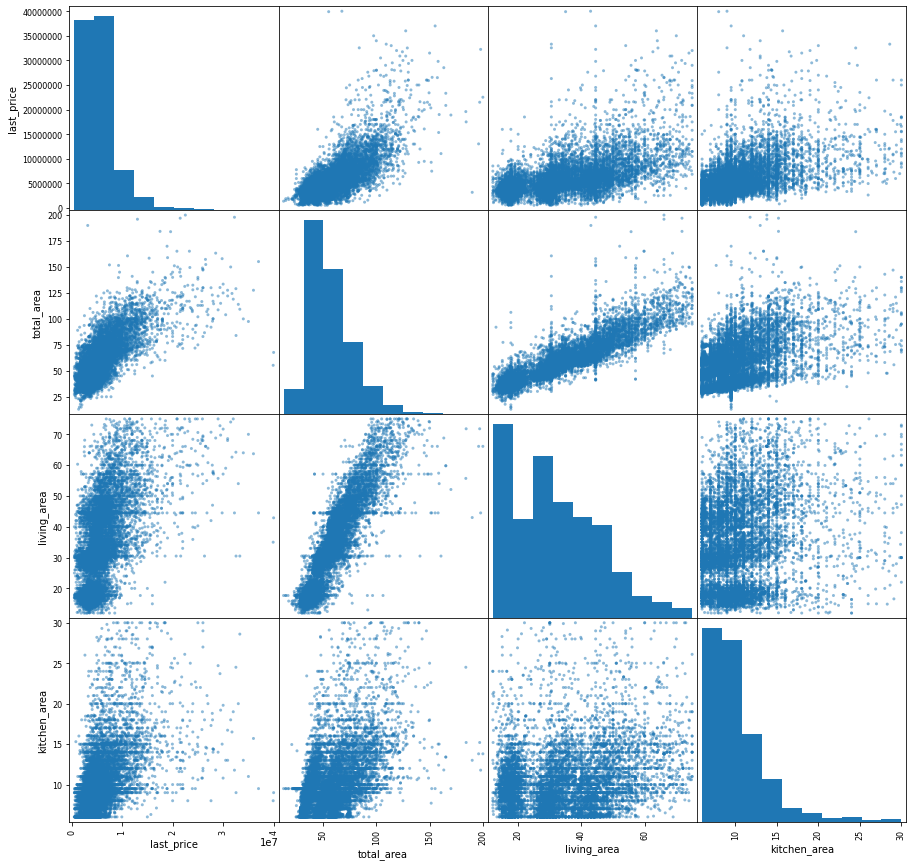

In [71]:
# оставим только те столбцы, которые коррелируют лучше всех
price_corr_filtered = data[['last_price', 'total_area', 'living_area', 'kitchen_area']]
pd.plotting.scatter_matrix(price_corr_filtered, figsize=(15, 15));

<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

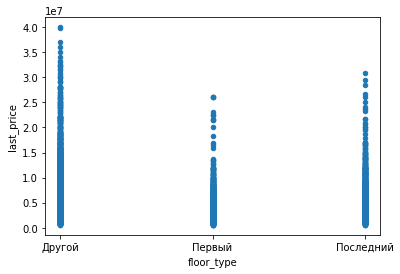

In [72]:
# посмотрим отдельно на соотношение цены и этажа
price_corr.plot(x='floor_type', y='last_price', kind='scatter')

Как мы видим, за первый этаж обычно просят максимум чуть больше 25 млн., а за последний есть предложения до 30 млн. Однако, все остальные часто оцениваются куда выше. Кол-во ОН в группах разное, но если ориентироваться на максимальные значения, то можно сказать, что первые этажи дешевле других. Возможно, дело в том, что это не самое удобное расположение (окна на уровне поверхности, шум в подъезде, соседство с магазинами и т.д.).

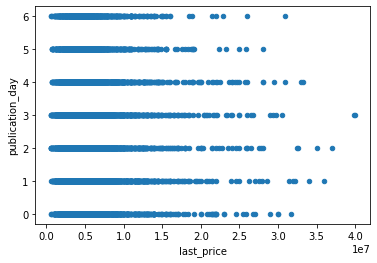

In [73]:
# проверим то же для дней, месяцев и годов
data[['last_price', 'publication_day']].plot(x='last_price', y='publication_day', kind='scatter');

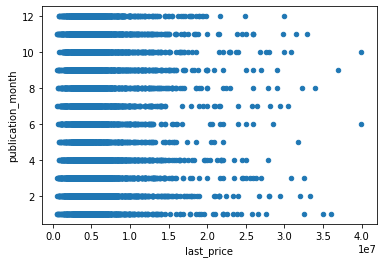

In [74]:
data[['last_price', 'publication_month']].plot(x='last_price', y='publication_month', kind='scatter');

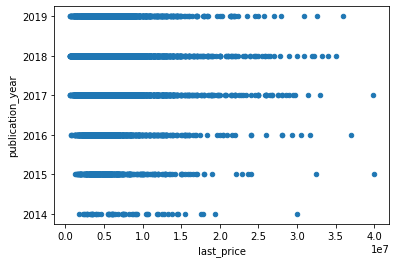

In [75]:
data[['last_price', 'publication_year']].plot(x='last_price', y='publication_year', kind='scatter');

Каких-либо неожиданных взаимосвязей нет. От дня недели суммма радикально не меняется. В зимние месяцы больше дорогих ОН, это может быть связано с тем, что в мае продавцы, наверное, склонны занижать стоимость, чтобы быстрее продать. Стоимость ОН по годам растет заметно, это может быть связано с уровнем инфляции, падением курса рубля, кризисами и другими макроэкономическими причинами.

#### Исследование цены кв. метра
Посчитаем среднюю цену в 10 городах, где подают больше всего объявлений, а также населенные пункты с максимальной и минимальной ценой.

In [76]:
# найдем самые «популярные» города для продажи ОН
popular_city = data['locality_name'].value_counts().sort_values(ascending=False).head(10)
popular_city

Санкт-Петербург      8308
Всеволожск            250
поселок Мурино        217
посёлок Шушары        194
Колпино               188
деревня Кудрово       184
Пушкин                158
посёлок Парголово     132
Гатчина               110
Сестрорецк            107
Name: locality_name, dtype: int64

In [77]:
# зафиксируем города
city_list = ['Санкт-Петербург', 'Всеволожск', 'поселок Мурино', 
             'посёлок Шушары', 'Колпино', 'деревня Кудрово', 
             'Пушкин', 'посёлок Парголово', 'Гатчина', 'Сестрорецк'
            ]
# выберем строки с нужными нам городами
city_dataframe = data.query('locality_name in @city_list')

# построим сводную таблицу со средними значениями кв.м. в этих городах и сразу округлим
round(city_dataframe.pivot_table(
    index='locality_name', 
    values='price_per_square_meter', 
    aggfunc='mean').sort_values('price_per_square_meter', ascending=False))

,price_per_square_meter
locality_name,
Санкт-Петербург,110929.0
Пушкин,105327.0
Сестрорецк,102069.0
деревня Кудрово,95672.0
посёлок Парголово,90920.0
поселок Мурино,87158.0
посёлок Шушары,79105.0
Колпино,75829.0
Гатчина,71041.0


Из взятого десятка в среднем самый дорогой квадратный метр в Санкт-Петербурге, а самый дешевый — во Всеволожске. Заодно посмотрим, где по всем данным самый дорогой и дешевый.

In [78]:
must_expensive = data.groupby('locality_name')['price_per_square_meter'].agg('mean').sort_values(ascending=False).index[0]
print(f'Самый дорогой квадратный метр в среднем в: {must_expensive}')
must_cheap = data.groupby('locality_name')['price_per_square_meter'].agg('mean').sort_values(ascending=False).index[-1]
print(f'Самый дешевый квадратный метр в среднем в: {must_cheap}')

Самый дорогой квадратный метр в среднем в: Санкт-Петербург
Самый дешевый квадратный метр в среднем в: поселок Совхозный


#### Исследование цены до центра Санкт-Петербурга

In [79]:
# возьмем из датафрейма строки только для Санкт-Петербурга
saint_peterburg_info = data.query('locality_name == "Санкт-Петербург"')

# вычислим среднюю цену для разных дистанций
mean_km = round(saint_peterburg_info.groupby('distance_to_center')['last_price'].agg(['mean']))
mean_km

,mean
distance_to_center,
0.0,9300000.0
1.0,9872865.0
2.0,10345730.0
3.0,8526564.0
4.0,9555013.0
5.0,10239132.0
6.0,9100537.0
7.0,8660909.0
8.0,8093218.0


<AxesSubplot:xlabel='distance', ylabel='mean'>

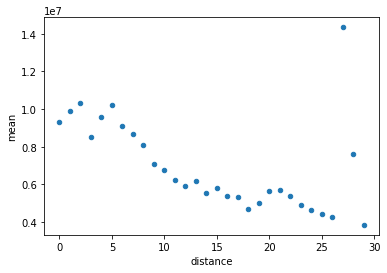

In [80]:
# продублируем столбец индексом для дальнейшей работы
mean_km['distance'] = mean_km.index

# построим диаграмму рассеяния, чтобы убедиться в наличии корреляции
mean_km.plot(x='distance', y='mean', kind='scatter')

Заметна отрицательная корреляция, хоть и не очень прямая. Есть прыжки значений и аномальные выбросы, но в целом можно сказать о снижении средней стоимости при удалении от центра города.

In [81]:
# какие есть пункты на 27 километре
data.query('distance_to_center == 27')['locality_name']

63                     Пушкин
221                    Пушкин
279      посёлок Металлострой
368           Санкт-Петербург
451                    Пушкин
557                    Пушкин
860                    Пушкин
1199                   Пушкин
1219                   Пушкин
1456     посёлок Металлострой
1574     посёлок Металлострой
2333     посёлок Металлострой
2335     посёлок Металлострой
2422     посёлок Металлострой
2989     посёлок Металлострой
3121     посёлок Металлострой
3365     посёлок Металлострой
3586                   Пушкин
3672                   Пушкин
3797     посёлок Металлострой
4011                   Пушкин
4249     посёлок Металлострой
4964     посёлок Металлострой
5080     посёлок Металлострой
5498     посёлок Металлострой
5509                   Пушкин
5638                   Пушкин
5678                   Пушкин
5700     посёлок Металлострой
6118                   Пушкин
6487     посёлок Металлострой
7574     посёлок Металлострой
7876                   Пушкин
7948     п

In [82]:
# какие есть цены для пунктов на этом километре
data.query('distance_to_center == 27 and locality_name == "посёлок Металлострой"')['last_price']

279      4500000
1456     4500000
1574     4700000
2333     3700000
2335     4300000
2422     3900000
2989     2800000
3121     3730000
3365     3300000
3797     4700000
4249     4800000
4964     4800000
5080     4250000
5498     2850000
5700     3300000
6487     2450000
7574     2870000
7948     5350000
8157     4800000
8821     4300000
9250     2350000
10770    2899000
11108    3450000
11771    2450000
Name: last_price, dtype: int64

In [83]:
data.query('distance_to_center == 27 and locality_name == "Пушкин"')['last_price']

63       16912000
221       8570000
451       6650000
557       8000000
860       4200000
1199     29500000
1219      7500000
3586      3650000
3672      7950000
4011     16600000
5509      5500000
5638      3080000
5678      5790000
6118      6300000
7876     16000000
7962      7500000
8229      7700000
9043      4290000
10686     9300000
10805     4100000
10980     9300000
11387     5299000
11446     6000000
Name: last_price, dtype: int64

In [84]:
# единственное совпадение для Питера
data.iloc[358]['last_price']

3550000

Не думаю, что дело в поселке Металлострой или Питере. А вот Пушкин больше похож на причину выбросов. Возможно, там недвижимость с видом на Большой Екатерининский дворец.

### Общий вывод

В ходе данного исследования мы разбирали массив объявлений в Санкт-Петербурге и области за несколько последних лет.

1. Сначала мы избавились от аномальных значений, где они были очевидны, и убрали пропуски, где это было возможно. Также в датафрейме были неявные дубликаты в названии населенных пунктов, пришлось их привести к одному написанию. Дополнительно исправили типы данных, где это было уместно и было необходимо.

2. Далее мы добавили дополнительные столбцы, которые нужны для дальнейшей работы (цена кв.м., расстояние до центра, разбитая информация по датам).

3. Следом мы изучили различные параметры и их распределение. Так или иначе большинство параметров стремились к нормальному распределению и согласовались со здравым смыслом. Самые интересные выводы:
    - Жилая площадь **с 20 до 28 кв.м.** выставлялась **4 раза реже**, чем **30 кв.м.**, и почти в **8 раз меньше**, чем **17 кв.м.**
    - Самая частая общая площадь — **45 кв.м.**
    - Объявления в **будни** публикуют **чаще**, чем в выходные дни
    - Пик объявлений приходится на **начало и конец зимы**, а спад более заметен **летом**.
    

4. Следующим шагом мы проанализировали, как быстро продавались квартиры. Выяснилось, что чаще всего укладывались в **1-2 месяца**. В **среднем же 158 дней, а медиана — 93 дня**. В датасете есть довольно много случаев, когда объявления висят годами. Их нужно будет проверить отдельно, так как причины долгой сдачи в срок могут быть разными. Желательно делать с возможностью посмотреть само объявление и историю его работы.

5. Далее мы проанализировали зависимость цены от разных факторов(площадей, кол-ва комнат, этажа, даты публикации). Выяснилось, больше всего коррелирует **общая площадь с ценой**, а также чуть хуже площадь кухни и жилой зоны, и этажа. День, месяц и год публикации объявления не коррелирует с ценой.

6. После этого исследовали цену квартиры для 10 населенных пунктов, в которых продавалось больше всего ОН. В Санкт-Петербурге ожидаемо и больше объявлений, и больше цена, равная в среднем **111 тыс. за кв.м**. Из топ-10 «дешевле» всех Всеволожск с **68 тыс. за кв.м.**

7. В конце мы искали взаимосвязь в Санкт-Петербурге между ценой и удаленностью от центра города. Нам удалось найти нечеткую отрицательную корреляцию, что говорит о том, что чем дальше от центра, тем в среднем ОН становятся дешевле.